/var/folders/l8/v51s8fxx7b34r635gds96p7c0000gn/T/ipykernel_6613/296415590.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(simulated_csds)


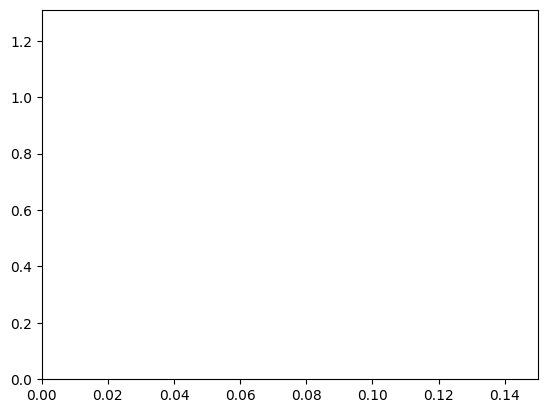

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from csd_calculation import csds, f
from csd_forward import simulated_csds
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, Output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_tensor = torch.from_numpy(f).float().to(device)
# y_train_tensor = torch.complex(torch.from_numpy(csds.real), torch.from_numpy(csds.imag)).to(device)
y_train_tensor = torch.tensor(simulated_csds)

#ASSUMPTION endogenous fluctuations = observation noise
class Spectral_DCM_Model(nn.Module):
    def get_rand_in_range(self, a, b, square=False):
        if square:
            return a - b * torch.rand(self.num_regions, self.num_regions, requires_grad=True, dtype=torch.float) + b
        return a - b * torch.rand(self.num_regions, requires_grad=True, dtype=torch.float) + b
    
    def __init__(self, num_regions):
        super().__init__()
        self.num_regions = num_regions
        self.alphas_e = nn.Parameter(self.get_rand_in_range(0,1))
        self.betas_e = nn.Parameter(self.get_rand_in_range(0, 1)) #0.5 - 3.5
        self.alphas_v = nn.Parameter(self.get_rand_in_range(0, 1))
        self.betas_v = nn.Parameter(self.get_rand_in_range(0, 1))
        self.A = nn.Parameter(self.get_rand_in_range(0, 1, square=True))
        
    def h(self, omega):
        i = torch.complex(torch.tensor(0.0), torch.tensor(1.0))
        hrf = (6 * (i * omega + 1) ** 10 - 1) / (5 * (i * omega + 1) ** 16)
        return hrf * torch.eye(self.num_regions)
    
    def g(self, omega, alphas, betas):
        # return (1/((omega + 1) ** 2)) * torch.eye(self.num_regions)
        return torch.diag(alphas * torch.full([self.num_regions], omega) ** (-1 * betas))

    def make_self_connections_neg(self):
        # with torch.no_grad():
            a = self.A
            v = -torch.exp(torch.diag(self.A))
            mask = torch.diag(torch.ones_like(v))
            out = mask*torch.diag(v) + (1. - mask)*a
            return out

    def forward_single_freq(self, omega):
        A = self.A
        I = torch.eye(self.num_regions)
        i = torch.complex(torch.tensor(0.0), torch.tensor(1.0))
        hrf = self.h(omega)
        hrf_T = torch.conj(hrf).T
        G_v = self.g(omega, self.alphas_v, self.betas_v) 
        G_v = G_v.to(torch.complex64)
        X = i * omega * I - A
        C = torch.linalg.solve(X, hrf, left=False)
        G_e = self.g(omega, self.alphas_e, self.betas_e) 
        result =  C @ G_v @ torch.conj(C).T + G_e


        hrf_T = torch.conj(hrf).T
        X_inv = torch.linalg.inv(i * omega * I - A)
        X_inv_t = torch.linalg.inv(-1 * i * omega * I - A.T)

        X_inv = X_inv.to(torch.complex64)
        G_v = G_v.to(torch.complex64)
        X_inv_t = X_inv_t.to(torch.complex64)
        G_e = G_e.to(torch.complex64)
        hrf_T = hrf_T.to(torch.complex64)

        result_orig = hrf @ X_inv @ G_v @ X_inv_t @ hrf_T + G_e
        # print(result - result_orig)
        return result

    def forward(self, freqs):
        csd_curves = torch.empty((self.num_regions ** 2, freqs.size(0)), dtype=torch.complex64)
        for (i, freq) in enumerate(freqs):
            csds = self.forward_single_freq(freq).view(-1)
            for (reg, csd_val) in enumerate(csds):
                csd_curves[reg, i] = csd_val  
        return csd_curves

    
    def plot(self, yhat, y_train_tensor):
        plt.autoscale(enable=True, axis='both', tight=None)
        print(self.A)
        print(self.alphas_e, self.alphas_v, self.betas_e, self.betas_v)
        for i in range(self.num_regions ** 2):
            g = yhat[i].detach().numpy()
            y = y_train_tensor[i].detach().numpy()
            plt.plot(f, g, label="simulated CSD")
            plt.plot(f, y, label="empirical CSD")
            plt.legend()
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude')
            plt.show()
    

def complex_mse_loss(output, target):
    loss =  ((output.real - target.real)**2).sum()
    return loss  

In [6]:
def plot_interactive(model, x_train_tensor, y_train_tensor):
    out = Output()  # Create an Output widget

    @out.capture()  # Capture output
    @interact(alphas_e=FloatSlider(min=-3, max=3, step=0.1, value=0.5),
              betas_e=FloatSlider(min=-3, max=3, step=0.1, value=0.5),
              alphas_v=FloatSlider(min=-3, max=3, step=0.1, value=0.5),
              betas_v=FloatSlider(min=-3, max=3, step=0.1, value=0.5),
              A=FloatSlider(min=-3, max=3, step=0.1, value=0.5))
    def update_plot(alphas_e, betas_e, alphas_v, betas_v, A):
        model.alphas_e.data = torch.tensor(alphas_e)
        model.betas_e.data = torch.tensor(betas_e)
        model.alphas_v.data = torch.tensor(alphas_v)
        model.betas_v.data = torch.tensor(betas_v)
        model.A.data = torch.tensor(A)

        yhat = model.forward(x_train_tensor)

        fig = go.Figure()

        for i in range(model.num_regions ** 2):
            y = y_train_tensor[i].detach().numpy().real
            yhat_single = yhat[i].detach().numpy().real


            fig.add_trace(go.Scatter(x=f, y=yhat_single, mode='lines', name="simulated CSD"))

        fig.update_layout(title="CSD Comparison",
                          xaxis_title='Frequency (Hz)',
                          yaxis_title='Magnitude',
                          legend=dict(x=0, y=1))

        fig.show()
    
    update_plot(0.5, 0.5, 0.5, 0.5, 0.5)
    return out

In [7]:
model = Spectral_DCM_Model(1).to(device)

# Call the interactive plot function
plot_interactive(model, x_train_tensor, y_train_tensor)

interactive(children=(FloatSlider(value=0.5, description='alphas_e', max=3.0, min=-3.0), FloatSlider(value=0.5…

Output()